# 2. 3D reconstruction of MERFISH mouse hypothalamic preoptic region

Then, we perform the _de novo_ 3D construction of MERFISH mouse hypothalamic preoptic region using STAIR. STAIR first learn and integrate spatial feature of slices using STAIR-Emb, defing inter-slice semantic distances based on the slice-level attention scores. Then, STAIR utilize a minimum spanning tree (MST) based on these distances to reconstruct the z-axis coordinates. Finally, the reconstructed z-coordinates guide STAIR-Loc to align the x- and y- axes.

In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import anndata as ad
import scanpy as sc
import matplotlib.pyplot as plt

from STAIR.emb_alignment import Emb_Align
from STAIR.utils import *

## Load data

In [2]:
adata = sc.read('./data/hypothalamic_preoptic.h5ad')
adata

AnnData object with n_obs × n_vars = 64373 × 155
    obs: 'Animal_ID', 'Animal_sex', 'Behavior', 'Bregma', 'Centroid_X', 'Centroid_Y', 'Cell_class', 'Neuron_cluster_ID', 'slices', 'Coord_X', 'Coord_Y', 'x', 'y', 'z', 'cell_type', 'batch', 'n_genes'
    var: 'n_cells'
    uns: 'batch_colors'
    obsm: 'spatial', 'spatial_2d_raw', 'spatial_2d_raw_rotate', 'spatial_2d_μm', 'spatial_2d_μm_rotate', 'spatial_3d', 'spatial_3d_raw', 'spatial_3d_raw_rotate', 'spatial_3d_μm', 'spatial_3d_μm_rotate'
    layers: 'noise1', 'noise2', 'noise3', 'noise4'

We visualize the cell types and 3D coordinates provided in the original research.

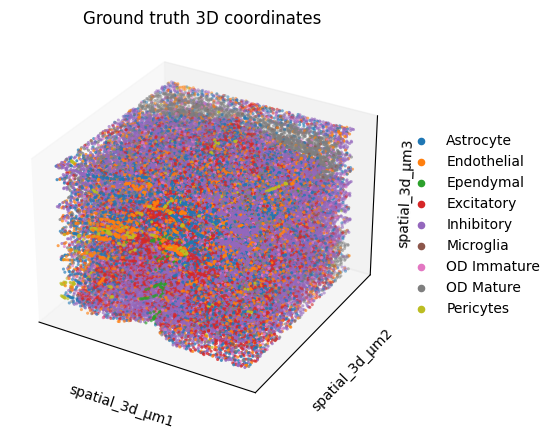

In [3]:
from matplotlib.pyplot import rc_context
with rc_context({'figure.figsize': (5,5)}):
    sc.pl.embedding(
                    adata,
                    basis="spatial_3d_μm",
                    na_color=(1, 1, 1, 0),
                    projection="3d",
                    s=0.1,
                    color="cell_type",
                    title='Ground truth 3D coordinates'
                )

To test the spatial construction capability of STAIR, we randomly rotate and translate the x- and y- axes of the second and subsequent slices.

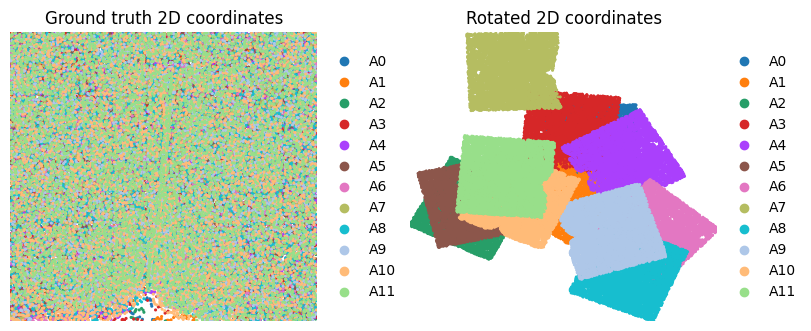

In [4]:
# rotate & translate

# import math
# def rotate(angle,valuex,valuey):
#     rotatex = math.cos(angle)*valuex -math.sin(angle)*valuey
#     rotatey = math.cos(angle)*valuey + math.sin(angle)* valuex
#     return np.hstack((rotatex[:,None], rotatey[:,None]))


# slices = sorted(list(set(adata_all.obs['z'])))

# adata_raw_list = [adata_all[adata_all.obs['z']==slice].copy() for slice in slices]

# angles = np.random.uniform(0,2*np.pi,len(slices)-1)
# tran_xs = np.random.uniform(-1800,1800,len(slices)-1)
# tran_ys = np.random.uniform(-1800,1800,len(slices)-1)
# pd.DataFrame(np.vstack((angles, tran_xs, tran_ys)).T, columns=['angle', 'tran_x', 'tran_y']).to_csv('trans_gt.csv')


# adata_raw_rotate_list = []

# for i in range(len(slices)):
#     slice_tmp = slices[i]
#     adata_raw_tmp = adata_raw_list[i]

#     if i !=0:
#         angle_tmp = angles[i-1]
#         tran_x_tmp = tran_xs[i-1]
#         tran_y_tmp = tran_ys[i-1]
#         adata_raw_tmp.obsm['spatial_2d_raw_rotate'] = rotate(angle_tmp,adata_raw_tmp.obsm['spatial_2d_raw'][:,0],adata_raw_tmp.obsm['spatial_2d_raw'][:,1])
#         adata_raw_tmp.obsm['spatial_2d_raw_rotate'] = np.vstack((adata_raw_tmp.obsm['spatial_2d_raw_rotate'][:,0] + tran_x_tmp, 
#                                                                  adata_raw_tmp.obsm['spatial_2d_raw_rotate'][:,1] + tran_y_tmp)).T
#         adata_raw_tmp.obsm['spatial_3d_raw_rotate'] = np.hstack((adata_raw_tmp.obsm['spatial_2d_raw_rotate'], adata_raw_tmp.obsm['spatial_3d_raw'][:,2][:,None]))

#         adata_raw_tmp.obsm['spatial_2d_μm_rotate'] = rotate(angle_tmp,adata_raw_tmp.obsm['spatial_2d_μm'][:,0],adata_raw_tmp.obsm['spatial_2d_μm'][:,1])
#         adata_raw_tmp.obsm['spatial_2d_μm_rotate'] = np.vstack((adata_raw_tmp.obsm['spatial_2d_μm_rotate'][:,0] + tran_x_tmp, 
#                                                                  adata_raw_tmp.obsm['spatial_2d_μm_rotate'][:,1] + tran_y_tmp)).T
#         adata_raw_tmp.obsm['spatial_3d_μm_rotate'] = np.hstack((adata_raw_tmp.obsm['spatial_2d_μm_rotate'], adata_raw_tmp.obsm['spatial_3d_μm'][:,2][:,None])) 
#     else:
#         adata_raw_tmp.obsm['spatial_2d_raw_rotate'] = adata_raw_tmp.obsm['spatial_2d_raw'] 
#         adata_raw_tmp.obsm['spatial_3d_raw_rotate'] = adata_raw_tmp.obsm['spatial_3d_raw'] 
#         adata_raw_tmp.obsm['spatial_2d_μm_rotate'] = adata_raw_tmp.obsm['spatial_2d_μm'] 
#         adata_raw_tmp.obsm['spatial_3d_μm_rotate'] = adata_raw_tmp.obsm['spatial_3d_μm']     
  
#     adata_raw_rotate_list.append(adata_raw_tmp)

# adata = ad.concat(adata_rotate_list)
# adata.write('./data/hypothalamic_preoptic.h5ad')

# Visualize
fig, axs = plt.subplots(1, 2, figsize=(8,3.2),constrained_layout=True)

[axs[i].axis('off') for i in range(2)]
axs[0].set_xlim([adata.obsm['spatial'].min(0)[0], adata.obsm['spatial'].max(0)[0]])
axs[0].set_ylim([adata.obsm['spatial'].min(0)[1], adata.obsm['spatial'].max(0)[1]])
axs[1].set_xlim([adata.obsm['spatial_2d_μm_rotate'].min(0)[0], adata.obsm['spatial_2d_μm_rotate'].max(0)[0]])
axs[1].set_ylim([adata.obsm['spatial_2d_μm_rotate'].min(0)[1], adata.obsm['spatial_2d_μm_rotate'].max(0)[1]])

sc.pl.embedding(adata, basis='spatial', color='batch', title='Ground truth 2D coordinates', frameon=False, s=20, show=False, ax=axs[0])
sc.pl.embedding(adata, basis='spatial_2d_μm_rotate', color='batch', title='Rotated 2D coordinates', frameon=False, s=20, show=False, ax=axs[1])

plt.show()
plt.close()

## Preprocess

In [5]:
result_path = construct_folder('hypothalamic')
keys_use = ['A0', 'A1', 'A2', 'A3', 'A4', 'A5', 'A6', 'A7', 'A8', 'A9', 'A10', 'A11']

In [6]:
# Construct the model 
emb_align = Emb_Align(adata, batch_key='batch', result_path=result_path)
emb_align.prepare()

# Preprocessing
emb_align.preprocess()
emb_align.latent()

100%|████████████████████████████████████████████████████████████████████████| 100/100 [11:19<00:00,  6.80s/it]


## Spatial embedding alignment

First, we align the spatial embeddings of these slices, which facilitates subsequent spatial reconstruction

In [7]:
# Construct the heterogeneous graph
emb_align.prepare_hgat( spatial_key = 'spatial_2d_μm_rotate',
                        slice_order = keys_use)

# learning & integrating
emb_align.train_hgat()
adata, atte = emb_align.predict_hgat()
atte.to_csv(f'{result_path}/embedding/attention.csv')

# clustering of spatial embedding
adata = cluster_func(adata, clustering='mclust', use_rep='STAIR', cluster_num=13, key_add='STAIR')

100%|████████████████████████████████████████████████████████████████████████| 150/150 [00:54<00:00,  2.76it/s]
R[write to console]:                    __           __ 
   ____ ___  _____/ /_  _______/ /_
  / __ `__ \/ ___/ / / / / ___/ __/
 / / / / / / /__/ / /_/ (__  ) /_  
/_/ /_/ /_/\___/_/\__,_/____/\__/   version 6.0.0
Type 'citation("mclust")' for citing this R package in publications.



fitting ...
  |======================================================================| 100%


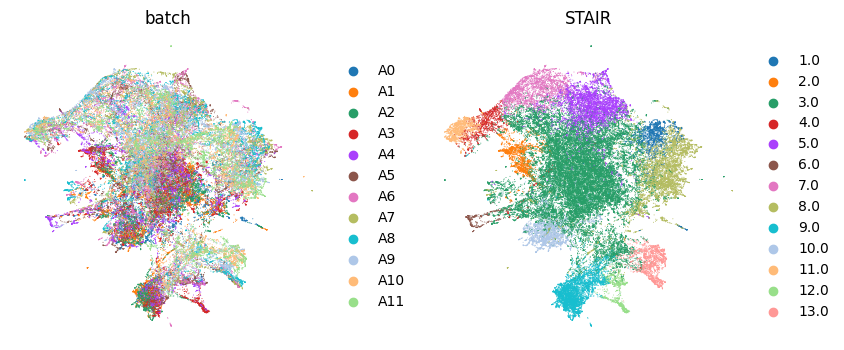

In [8]:
# Visualization

sc.pp.neighbors(adata, use_rep='STAIR')
sc.tl.umap(adata, min_dist=0.2)

from matplotlib.pyplot import rc_context
with rc_context({'figure.figsize': (4,4)}):
    sc.pl.umap(adata, color=['batch', 'STAIR'], frameon=False, ncols=3, show=True)

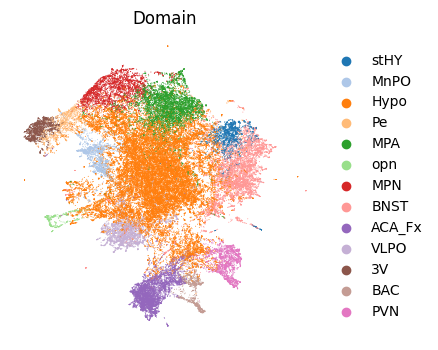

In [9]:
# annotation
adata.obs['Domain'] = adata.obs['STAIR'].replace({ '1.0': 'stHY', '10.0': 'VLPO', '11.0': '3V', '12.0': 'BAC', '13.0': 'PVN', '2.0': 'MnPO', 
                                                   '3.0': 'Hypo', '4.0': 'Pe', '5.0': 'MPA', '6.0': 'opn', '7.0': 'MPN', '8.0': 'BNST', '9.0': 'ACA_Fx'}
                                                )

adata.obs['Domain'] = adata.obs['Domain'].astype('category').cat.set_categories(['stHY', 'MnPO', 'Hypo', 'Pe', 'MPA', 'opn', 'MPN', 'BNST', 'ACA_Fx', 'VLPO', '3V', 'BAC', 'PVN'])

import matplotlib
hex_colors = [plt.matplotlib.colors.rgb2hex(color) for color in plt.cm.tab20.colors]
domains = adata.obs['Domain'].cat.categories.tolist()
adata.uns['Domain_colors'] = hex_colors[:len(set(adata.obs['Domain']))]

with rc_context({'figure.figsize': (4,4)}):
    sc.pl.umap(adata, color=['Domain'], frameon=False, ncols=3, show=True)

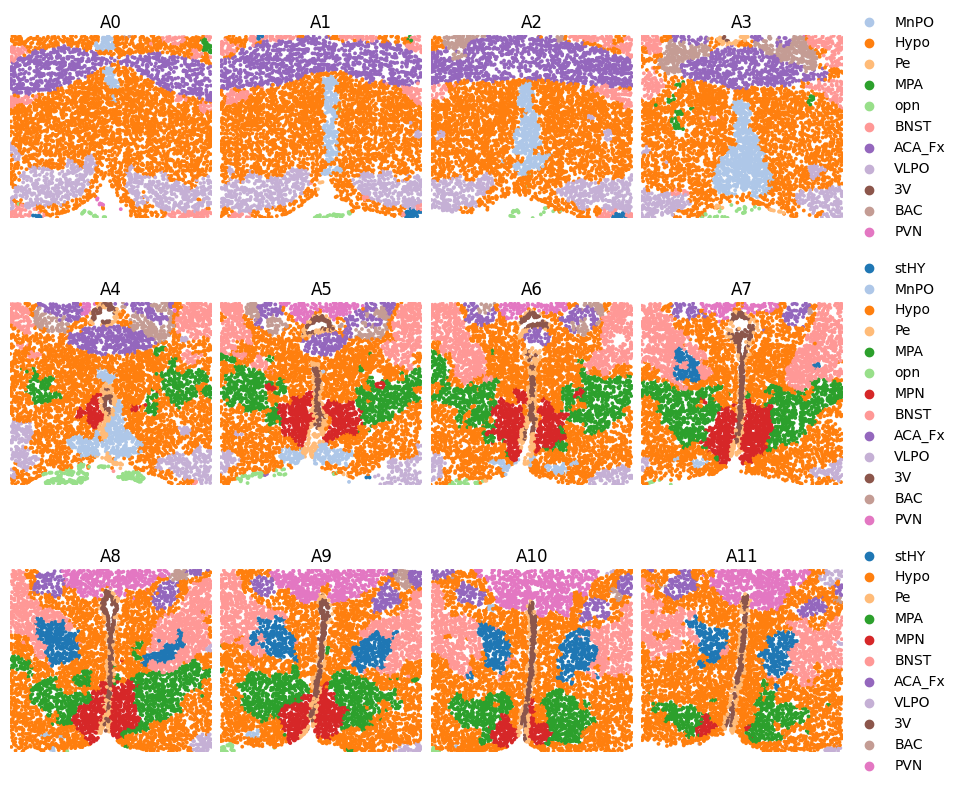

In [10]:
# 2D visualization of spatial domain

n_row = 3
n_col = 4
fig, axs = plt.subplots(n_row, n_col, figsize=(9.5,7.8),constrained_layout=True)

index = 0
for i in range(n_row):
    for j in range(n_col):
        axs[i,j].get_xaxis().set_visible(False)
        axs[i,j].get_yaxis().set_visible(False)
        axs[i,j].axis('off')
        axs[i,j].set_xlim([adata.obsm['spatial'].min(0)[0], adata.obsm['spatial'].max(0)[0]])
        axs[i,j].set_ylim([adata.obsm['spatial'].min(0)[1], adata.obsm['spatial'].max(0)[1]])
        if index < len(keys_use):
            key = keys_use[index]
            adata_tmp = adata[adata.obs['batch']==key].copy()
            if j<(n_col-1):
                sc.pl.embedding(adata_tmp, basis='spatial', color='Domain', title=key, frameon=False, legend_loc='right', s=30, show=False, ax=axs[i,j])
                j += 1 
            else:
                sc.pl.embedding(adata_tmp, basis='spatial', color='Domain', title=key, frameon=False, s=30, show=False, ax=axs[i,j])
                i += 1
                j = 0
        
        index += 1
plt.show()
plt.close()

## Reconstruction in z-axis

Next, we focus on the z-axis reconstruction based on slice level attention in the STAIR-Emb module. We visualize the inter-slice attention scores using heatmap.

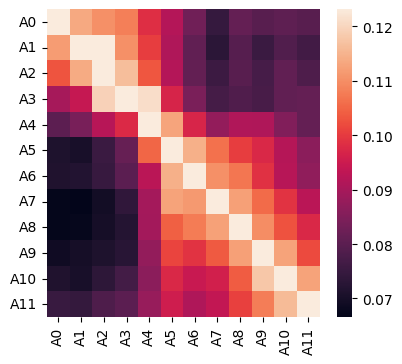

In [11]:
import seaborn as sns
vmax = atte[atte!=1].max().max()
vmin = atte[atte!=1].min().min()
plt.figure(figsize=(4.4,4))
sns.heatmap(atte, vmax=vmax, vmin=vmin)
plt.show()
plt.close()

There are higher attention scores between physically closer slices. We quantify the correlation between attention scores and spatial distances.

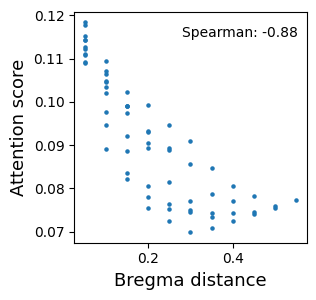

In [12]:
# attention-spatial consistency

from scipy.stats import spearmanr

use = adata.obs[['batch', 'Bregma']].drop_duplicates()
use.index = use['batch']
use = use['Bregma']

attes = []
dists = []
for i in keys_use:
    for j in keys_use:
        if (i != j) & (i < j):
            atte_tmp = (atte.loc[i,j] + atte.loc[j,i]) / 2
            dist_tmp = abs(use[i] - use[j])
            attes.append(atte_tmp)
            dists.append(dist_tmp)


plt.figure(figsize=(3,3))
plt.scatter(dists, attes, s=5)
plt.xlabel('Bregma distance', fontsize=13)
plt.ylabel('Attention score', fontsize=13)
plt.text(0.28, 0.115, 'Spearman: ' + str(round(spearmanr(attes, dists)[0], 2)))
plt.show()
plt.close()

The strong correlation prompts us to reconstruct the z-axis coordinates according to attention scores. 

In [13]:
from STAIR.loc_prediction import sort_slices
dists = sort_slices(atte, start='A11')
dists

{'A11': 0.0,
 'A10': 0.885701893,
 'A9': 1.770533613,
 'A8': 2.6595647380000003,
 'A7': 3.5472318000000005,
 'A6': 4.436391565000001,
 'A5': 5.322045235000001,
 'A4': 6.213104990000001,
 'A3': 7.103802040000001,
 'A2': 7.985913619000001,
 'A1': 8.867480269000001,
 'A0': 9.754753862000001}

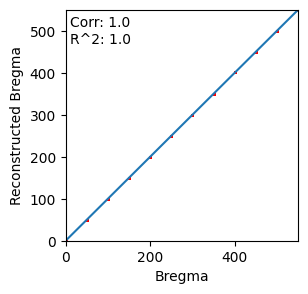

In [14]:
import scanpy as sc
import numpy as np

adata.obs['z_rec'] = adata.obs['batch'].replace(dists).astype(float)
adata.obs['z_rec'] = (adata.obs['z_rec']- adata.obs['z_rec'].min()) / (adata.obs['z_rec'].max() - adata.obs['z_rec'].min())
adata.obs['z_rec']

z_max, z_min = adata.obs['z'].max(), adata.obs['z'].min()
adata.obs['z_rec'] = adata.obs['z_rec'] * (z_max - z_min) + z_min
adata.obs['z_rec']

from scipy.stats import pearsonr
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import numpy as np

vmin = np.array(adata.obs['z_rec'].tolist() + adata.obs['z'].tolist()).min()
vmax = np.array(adata.obs['z_rec'].tolist() + adata.obs['z'].tolist()).max()

plt.figure(figsize=(3,3))
plt.plot([vmin, vmax],[vmin, vmax])
plt.scatter(adata.obs['z'], adata.obs['z_rec'], s=1, c='r')
plt.text(10,470,'Corr: ' + str(pearsonr(adata.obs['z'], adata.obs['z_rec'])[0].round(2)) + '\n' + \
         "R^2: " + str(r2_score(adata.obs['z'], adata.obs['z_rec']).round(2))
         )
plt.xlim([vmin, vmax])
plt.ylim([vmin, vmax])
plt.xlabel('Bregma')
plt.ylabel('Reconstructed Bregma')
plt.show()
plt.close()

## Spatial location alignment in x-axis and y-axis

Finally, STAIR-Loc aligns the x- and y- axes of slices based on the reconstructed z-coordinates.

In [15]:
adata.obs[['batch', 'z_rec']].drop_duplicates().sort_values('z_rec', ascending=False)['batch'].tolist()

['A0', 'A1', 'A2', 'A3', 'A4', 'A5', 'A6', 'A7', 'A8', 'A9', 'A10', 'A11']

In [16]:
from STAIR.loc_alignment import Loc_Align

keys_order = adata.obs[['batch', 'z_rec']].drop_duplicates().sort_values('z_rec', ascending=False)['batch'].tolist()
loc_align = Loc_Align(adata, batch_key='batch', batch_order=keys_order, result_path=result_path)

loc_align.init_align(   emb_key = 'STAIR',
                        spatial_key = 'spatial_2d_μm_rotate',
                        num_mnn = 1  )

loc_align.detect_fine_points(  domain_key = 'Domain',
                               slice_boundary = True, 
                               domain_boundary = True, 
                               num_domains = 1,
                               alpha = 70,
                               return_result = False)

loc_align.plot_edge(spatial_key = 'transform_init',
                    figsize = (6,6),
                    s=2)

adata = loc_align.fine_align()

# import pandas as pd
# transform_fine = pd.DataFrame(adata.obsm['transform_fine'], index=adata.obs_names, columns=['x', 'y'])
# transform_init = pd.DataFrame(adata.obsm['transform_init'], index=adata.obs_names, columns=['x', 'y'])
# transform_fine.to_csv(f'{result_path}/location/transform_fine.csv')
# transform_init.to_csv(f'{result_path}/location/transform_init.csv')

Performing initial alignment of the 1 pair of data...
Finding similar pairs using STAIR...
Aligning slices using 645 pairs of similar spots!
Performing initial alignment of the 2 pair of data...
Finding similar pairs using STAIR...
Aligning slices using 662 pairs of similar spots!
Performing initial alignment of the 3 pair of data...
Finding similar pairs using STAIR...
Aligning slices using 560 pairs of similar spots!
Performing initial alignment of the 4 pair of data...
Finding similar pairs using STAIR...
Aligning slices using 585 pairs of similar spots!
Performing initial alignment of the 5 pair of data...
Finding similar pairs using STAIR...
Aligning slices using 635 pairs of similar spots!
Performing initial alignment of the 6 pair of data...
Finding similar pairs using STAIR...
Aligning slices using 695 pairs of similar spots!
Performing initial alignment of the 7 pair of data...
Finding similar pairs using STAIR...
Aligning slices using 672 pairs of similar spots!
Performing in

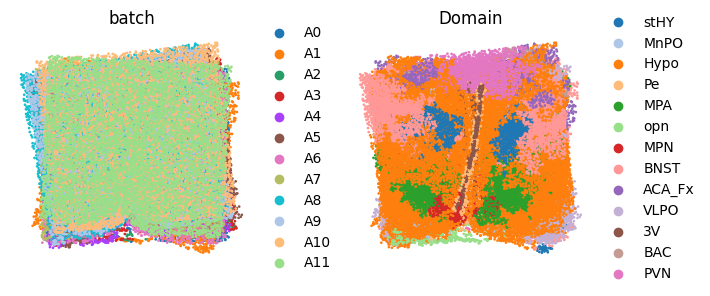

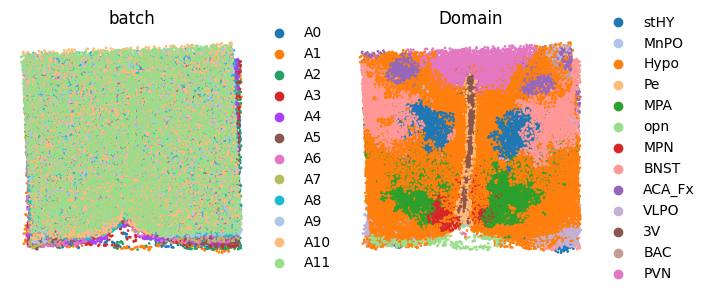

In [17]:
adata.obs['Domain'] = adata.obs['Domain'].astype('category').cat.set_categories(['stHY', 'MnPO', 'Hypo', 'Pe', 'MPA', 'opn', 'MPN', 'BNST', 'ACA_Fx', 'VLPO', '3V', 'BAC', 'PVN'])
adata.uns['Domain_colors'] = hex_colors[:len(set(adata.obs['Domain']))]

## initial alignment 
with rc_context({'figure.figsize': (3,3)}):
    sc.pl.embedding(adata, basis='transform_init', color=['batch', 'Domain'],
                    frameon=False, ncols=2, show=True, s=15)

## fine alignment
with rc_context({'figure.figsize': (3,3)}):
    sc.pl.embedding(adata, basis='transform_fine', color=['batch', 'Domain'],
                    frameon=False, ncols=2, show=True, s=15)

We evaluate the accuracy of positional alignment quantitatively.

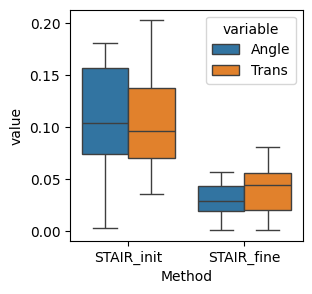

In [18]:
from STAIR.location.transformation import best_fit_transform

import math
def cacul_angle(cos_val, sin_val):
    tan_val = math.sqrt(1 - cos_val**2) / cos_val  # 利用三角恒等式求解正切值
    if cos_val > 0:
        if sin_val >= 0:
            theta = math.atan(tan_val)  # 计算角度，注意使用math.atan函数
        else:
            theta = 2*math.pi - math.atan(tan_val)
    else:
        if sin_val >= 0:
            theta = math.pi - math.atan(tan_val)
        else:
            theta = math.pi + math.atan(tan_val)
    return theta


angle_inits = []
angle_fines = []
trans_inits = []
trans_fines = []
for key in keys_use[1:]:
    init = best_fit_transform(adata[adata.obs['batch']==key].obsm['transform_init'], adata[adata.obs['batch']==key].obsm['spatial_2d_μm'])[1:]
    fine = best_fit_transform(adata[adata.obs['batch']==key].obsm['transform_fine'], adata[adata.obs['batch']==key].obsm['spatial_2d_μm'])[1:]
    angle_inits.append(cacul_angle(cos_val=init[0][0,0], sin_val=init[0][0,0]))
    angle_fines.append(cacul_angle(cos_val=fine[0][0,0], sin_val=fine[0][0,0]))
    trans_inits.append(np.array(init[1]))
    trans_fines.append(np.array(fine[1]))

error_init = pd.DataFrame(np.array(trans_inits), index=keys_use[1:], columns=['trans_x', 'trans_y'])
error_fine = pd.DataFrame(np.array(trans_fines), index=keys_use[1:], columns=['trans_x', 'trans_y'])
error_init['Angle'] = angle_inits
error_init['Method'] = 'STAIR_init'
error_fine['Angle'] = angle_fines
error_fine['Method'] = 'STAIR_fine'
error = pd.concat([error_init, error_fine])

def square(x):
    return (x ** 2)

error['Trans'] = np.sqrt(error['trans_x'].map(square) + error['trans_y'].map(square))/1000
error = error.iloc[:,2:]

error.melt(id_vars=['Method'])

plt.figure(figsize=(3,3))
sns.boxplot(x='Method', y='value', hue='variable', data=error.melt(id_vars=['Method']))
plt.show()
plt.close()

## 3D Visualization

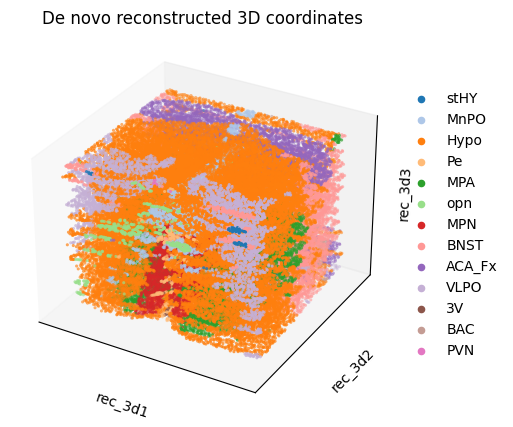

In [19]:
# 3D

adata.obsm['rec_3d'] = adata.obs[['x_aligned', 'y_aligned', 'z_rec']].values

with rc_context({'figure.figsize': (5,5)}):
    sc.pl.embedding(
                    adata,
                    basis="rec_3d",
                    na_color=(1, 1, 1, 0),
                    projection="3d",
                    color="Domain",
                    title='De novo reconstructed 3D coordinates'
                   )

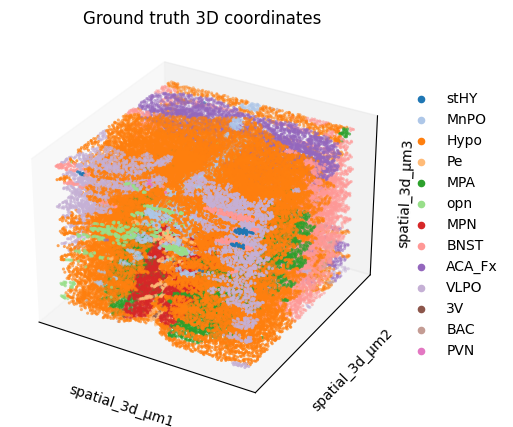

In [20]:
with rc_context({'figure.figsize': (5,5)}):
    sc.pl.embedding(
                    adata,
                    basis="spatial_3d_μm",
                    na_color=(1, 1, 1, 0),
                    projection="3d",
                    color="Domain",
                    title='Ground truth 3D coordinates'
                )

## Save

In [21]:
adata.write(f'{result_path}/adata.h5ad')